In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn import metrics

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli, Normal
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm

from plotting import make_vae_plots

from torchvision.transforms import ToTensor

transform_to_tensor = ToTensor()
#transform_to_tensor(images[0]).shape

c:\Users\Peetz\miniconda3\envs\02456\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
p = Bernoulli(logits=torch.zeros((1000,)))


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        eps = torch.empty_like(self.mu).normal_()
        return self.mu + self.sigma * eps
    
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return - ((z - self.mu)**2)/(2*self.sigma**2) - torch.log(self.sigma) - math.log(math.sqrt(2 * math.pi)) # <- your code
    
    def mu(self):
        return(self.mu, self.sigma)

# Generate synthetic data

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.distributions import Distribution
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

In [5]:
class SynthNN(nn.Module):
    def __init__(self, hidden_size = 6):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=3, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=10),
        )
    def forward(self, Z):
        return self.function(Z)


def simulate_synthetic_data(samples, function):
    envs1 = np.array([0.2, 2, 3, 5])
    E = np.random.choice([0,1,2,3], size = samples)

    env = envs1[E]
    Z1 = env + np.random.normal(0, 1, size = samples)
    Z2 = 2*env + np.random.normal(0, np.sqrt(2), size = samples)
    Y = Z1 + Z2 + np.random.normal(0, 1, size = samples)
    Z3 = Y + np.random.normal(0, 1, size = samples)
    Z = np.stack([Z1, Z2, Z3], axis = 1)

    if function == 'identity':
        X = Z
    elif function == 'linear':
        S = np.random.normal(size = (2,10))
        X = Z@S
    elif function == 'nonlinear':
        synthnn = SynthNN()
        X = synthnn(torch.tensor(Z).float()).detach().numpy()
    
    return X, Y, E, Z, env

class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        E = torch.tensor(E) #From Peter
        # self.E = torch.nn.functional.one_hot(torch.tensor(E))
        self.E = torch.nn.functional.one_hot(E.long())
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))
        
model = SynthNN()
#x, y, e, z, env = simulate_synthetic_data(100, "nonlinear")

In [6]:
#Generate data
torch.manual_seed(1)
X, Y, envs, Z, E = simulate_synthetic_data(20000, 'nonlinear')
dset1 = EnvDataset(X[:15000],Y[:15000],envs[:15000])
train_loader = DataLoader(dset1, batch_size=128)


dset2 = EnvDataset(X[5000:],Y[5000:],envs[5000:])
test_loader = DataLoader(dset2, batch_size=128)

#test = next(iter(train_loader))
#print(test[2])


# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]
environment = sample[2]


# Plotting the base data distribution

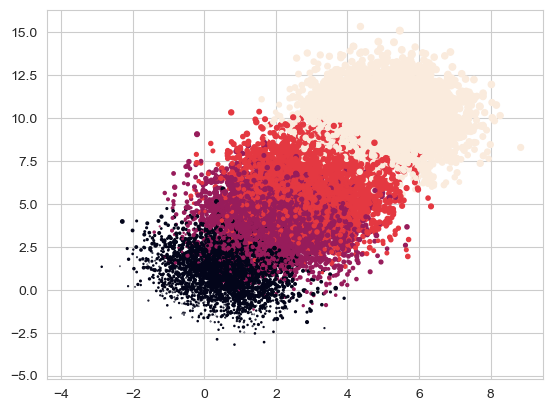

In [8]:
# Plotting base data
orgFrame = pd.DataFrame(Z)
plt.scatter(orgFrame[0],orgFrame[1], orgFrame[2], c = E)

# Phase 1 - VAE

In [9]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VAE(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VAE, self).__init__()
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.beta = 1

        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        ## setting the prior to a vector consisting of zeros with dimensions (1,2*latent_features)
        # self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
        '''
        According to page 31-32 the iVAE consist of 7 NNs:
        1. TNN prior
        2. lambdaNN prior
        3. lambdaf prior
        
        4. X-encoder (Classic image CNN)
        5. (Y, E)-encoder
        6. (X, Y, E)-merger/encoder

        7. Decoder

        1-3: Learn priors based on the label distribution for the given environment
        4-6: Encoding X, encoding Y and E and merging these two encoders, to generate a 
             qz which is conditional on the environment.
        7: Decodes the latent space through pz. Since the latent space now contain some measure
           of environment, then this distribution pz is consequentially conditioned on the environment

        NN 1-3 can be found in the variational inference funktion.
        '''
        ####
        #1/8
        self.Lambdaflinear_prior = nn.Sequential(
            nn.Linear(in_features = 2, out_features = 50),
            nn.Linear(in_features = 50, out_features = 4)
        )


        #2/8
        self.Lambdafnl_prior = nn.Sequential(
            nn.Linear(in_features = 5, out_features = 128),
            nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 6)
        )

        #3/8
        self.TNN_prior = nn.Sequential(
            nn.Linear(in_features = 3, out_features = 128),
            nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 3)
        )

        #4/8
        self.LambdaNN = nn.Sequential(
            nn.Linear(in_features = 5, out_features = 128),
            nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 1)
        )

        #5/8
        self.LinearEncoder = nn.Sequential(
            nn.Linear(in_features = latent_features, out_features = 50),
            nn.Linear(in_features = 50, out_features = 3)
        )

        #6/8
        self.NonLinearEncoder = nn.Sequential(
            nn.Linear(in_features = 15, out_features = 128),
            nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features = 6)
        )

        #7/8
        self.LinearDecoder = nn.Sequential(
            nn.Linear(in_features = latent_features, out_features = 50),
            nn.Linear(in_features = 50, out_features = 2),
        )

        #8/8
        self.NonLinearDecoder = nn.Sequential(
            nn.Linear(in_features = 3, out_features = 128),
            nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 10),
        )

        self.relu = nn.ReLU()
        

    #Funktion fra Thea, ved ikke helt hvor hun har den fra - ligner dog equation (2)
   
    
    def prior(self, batch_size:int=1, )-> Distribution:
        """return the distribution `p(z)`"""
        #Expand prior_params til at være samme antal rækker som i den valgte batch size således at der fås
        #en tensor med dimensionerne (batch_size, 2*latent_features), som så kan udfyldes med
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        #chunk opdeler prior_params i to dele, de første 0-latent_features kollonner indeholder mu og 
        #de sidste n_latent_features inde holder sigmaerne. Nu er der to tensors, som begge har dim
        #(batch_size, n_latent_features). Værdierne i disse tensors, kan bruges til at sample hvordan
        #latent space ser ud (Den der hedder 'latent interpolations' i plots i bunden.)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        #BEMÆRK at at det er log_sigma, dvs. at når den inputtes i ReparameterizedDiagonalGaussian så fås mu = 0, sigma = 1
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    #NN 4/7
    def encoder(self, x, y, e):

        #x = relu(self.encoderCNN1(x))
        #x = relu(self.encoderCNN2(x))
        #x = relu(self.encoderCNN3(x))
        #x = x.view(x.size(0), -1) #NN 4/7
        
        #ye = torch.cat((y, e), dim = 1)
        # ye = ye.to(torch.float32)
        # ye = self.YEencoder(ye) #NN 5/7

        xye = torch.cat((x,y,e), dim = 1)
        #print(xye.size())
        xye = self.NonLinearEncoder(xye)
        # xye = self.XYEmerger(xye) #NN 6/7
        #mu, log_sigma =  x.chunk(2, dim=-1)
        
        return xye
   
    #NN 7/7
    def decoder(self, z):
        x = self.NonLinearDecoder(z)
        return x
        
    def posterior(self, x:Tensor, y:Tensor, e:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x, y, e)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        #print(z.size())
        px_loc = self.decoder(z)
        #print(px_loc.size())
        #px_loc = px_loc.view(-1, *self.input_shape) # reshape the output #old
        #sandsynlighedsfordeling der giver 1 eller 0, baseret p� log-odds givet i logits input fra p(x|z).
        #Dvs. at px_logits angiver sandsynligheden for at det givne pixel er henholdsvist r�d,gr�n,bl�. Pixel v�rdien
        #er enten 0 eller 1. N�r man sampler fra bernoulli fordelingen f�s dermed et billede, som givet z, giver en figur,
        #som er bestemt af de sandsynligheder der er i px_logits (p(x|z)). Dvs. at for et givet latents space, kan en
        #figur/et tal reproduceres ud fra de beregnede sandsynligheder og den efterf�lgende sample fra Bernoulli fordelingen.
        #return Bernoulli(logits=px_loc, validate_args=False)
        return Normal(loc=px_loc, scale = 0.1*torch.ones(px_loc.shape))
        

    def forward(self, x, y, e) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        pz = self.prior(batch_size=x.size(0))
        #### Run through ENCODER and calculate mu and sigma for latent space sampling
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x, y, e)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        #### LATENT SPACE
        z = qz.rsample()
        
        #### DECODER
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz,'qz': qz, 'z': z}

    def VariationalInference(self, x, y, e):
        
        # forward pass through the model to get the encoder and decoder outputs
        parameters_and_latent_space = self.forward(x, y, e)

        # unpack encoder parameters from (px), decoder parameters (qz) and the latent space (z)
        px, pz, qz, z = [parameters_and_latent_space[k] for k in ["px", "pz", "qz", "z"]]
        #px_ze, qz_xye, z = [parameters_and_latent_space[k] for k in ["px", "qz", "z"]]

        

        # DEFINE THE PRIOR p(z)
        #### PRIOR
        z_temp = z.detach().requires_grad_(requires_grad = True)
        
        #pz_params = self.prior_params(z_temp, y.detach(), e.detach())
        #prior calculation from page 28 (til differentiering ifm. eq. 64 skal dette ikke v�re logget, men n�r
        # elbo loss beregnes, skal man huske at tage log at denne v�rdi jvf. p. 28)
        #pz_ye =  self.prior_pdf(z_temp, *pz_params)
        #OBS: HER SKAL DER IKKE ANVENDES LOG-PROBS AF PZ_YE JVF. SM DELEN AF EQ. (64) P� SIDE 28
        #dpz_ye = torch.autograd.grad(pz_ye.mean(), z_temp, create_graph = True, retain_graph=True)[0]

        #ddpz_ye = torch.autograd.grad(dpz_ye.mean(), z_temp, create_graph = True, retain_graph=True)[0] #changed sum() to mean()
        #ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph=True)[0] #original

        #### SM loss SM loss SM loss SM loss SM loss SM loss SM loss SM loss ####
        #Calculation from page 28 equation 64
        #SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)
        #### SM loss SM loss SM loss SM loss SM loss SM loss SM loss SM loss ####

        #### ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ####
        # evaluate log probabilities
        # Skal jvf. s. 32 �ndres til at v�re en normal fordeling i stedet for en
        # bernoulli fordeling, og her skal mean v�re outputtet af decoderen og varians skal
        #blot s�ttes til at v�re 0.01
        #log_px_ze = reduce(px.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        
        ####(old)log_pz = reduce(pz.log_prob(z)) #log(p(z)): 
        #log_pz_ye = torch.log(pz_ye)#Sandsynligheden for at observere vores latent space, givet at
        #latent space f�lger en standard-normal fordeling (Jo h�jere sandsynlighed jo bedre)
        
        #log_qz_xye = reduce(pz.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne v�rdi skal helst v�re lav?
        
        # compute the ELBO: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Fors�ger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        
        """
            Pz,qz, px for the VAE
        """
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        kl = log_qz- log_pz

        #kl = log_qz_xye - qz.detach() #OBS: DENNE BEREGNING SKAL M�SKE �NDRES TIL AT TAGE LOG AF PZ_YE JVF P. 28.
        
        elbo = log_px - kl
        ####
        beta_elbo = log_px - self.beta * kl
        # loss
        loss = -(beta_elbo.mean())
        #print("SM: {}. elbo: {} = log_px_ze: {} + log_pz_ye: {} - log_qz_xye: {}".format(SM.mean(), elbo.mean(),log_px_ze.mean(),pz_ye.mean(),log_qz_xye.mean()))

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
        
        outputs = parameters_and_latent_space
        return loss, diagnostics, outputs

latent_features = 3 #Husk at opdater denne parameter nede i 'initialization', hvis den skal bruges i VAE loopet ogs�
batch_size = 128
vae = VAE(images[0].shape, latent_features)
print(vae)

VAE(
  (Lambdaflinear_prior): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=4, bias=True)
  )
  (Lambdafnl_prior): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=6, bias=True)
    (2): ReLU()
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
  (TNN_prior): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=6, bias=True)
    (2): ReLU()
    (3): Linear(in_features=6, out_features=3, bias=True)
  )
  (LambdaNN): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=6, bias=True)
    (2): ReLU()
    (3): Linear(in_features=6, out_features=1, bias=True)
  )
  (LinearEncoder): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=3, bias=True)
  )
  (

# ELBO

In [10]:
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]#.reshape(-1,1)
environment = sample[2]#.reshape(-1,1)

x = images
y = label
e = environment

loss, diagnostics, outputs = vae.VariationalInference(x.float(), y.float(), e.float())
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    315.876, shape: []
elbo   | mean =   -315.876, shape: [128]
log_px | mean =   -314.059, shape: [128]
kl     | mean =      1.816, shape: [128]


# Initialization

In [11]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 3 #Hyper parameter
vae = VAE(images[0].shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) #Hyper parameter, tilf�j evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

torch.manual_seed(2)
num_epochs = 50 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)
sample_counter = 0
# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in tqdm(train_loader):
        sample_counter += 1
        
        x = sample[0]
        x = x.to(device)

        y = sample[1]#.reshape(-1,1)
        y = y.to(device)

        e = sample[2]#.reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = vae.VariationalInference(x.float(), y.float(), e.float())
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    px = outputs['px']
    samples = px.sample()


>> Using device: cpu


100%|██████████| 118/118 [00:00<00:00, 260.78it/s]


# Phase 2 - PC algorithm based on latent variable

(page 6-7)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


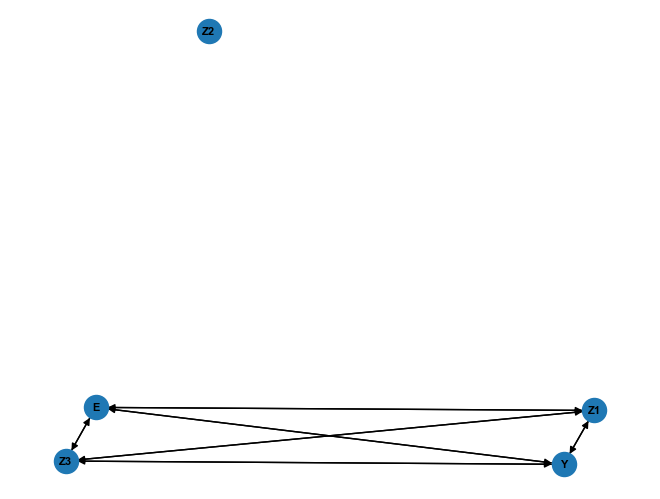

In [12]:
#Dummy code for the testing of the PC algorithm to ensure the model data is prepared in the right format
import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

#names = np.array(["A","B", "C", "D", "E"])
#data_df = pd.DataFrame(data, columns = names)
#pc_test = PC(CItest = 'gaussian', alpha = 0.05, verbose=False).create_graph_from_data(data_df[names[permutation]])

#nx.draw(pc_test, with_labels=True, font_weight='bold')
#plt.show()

#X, Y, envs
#cmnist = ConcatDataset([X, Y, E])
#loader = DataLoader(cmnist, batch_size = 8000, batch_sampler = None)
#dset = EnvDataset(X[:4000],Y[:4000],envs[:4000])
#loader = DataLoader(dset, batch_size=4000, drop_last=True)
loader = DataLoader(dset1, batch_size=15000)
sample = next(iter(loader))

x = sample[0]
y = sample[1]#.reshape(-1,1)
e = sample[2]#.reshape(-1,1)

output = vae.forward(x.float(), y.float(), e.float())

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

enviro = np.zeros((len(e),1))
for i in range(0,4):
    inde = e[:,i] == 1
    enviro[inde] = i+1

z_df = pd.DataFrame(z.detach())
y_df = pd.DataFrame(y.detach())
e_df = pd.DataFrame(enviro)

df = z_df; df['Y'] = y_df; df['E'] = e_df
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'E']
df.head()

pc = PC(alpha = 0.1)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

### Bi-directional graph. Thus we increase $\alpha$.

We allow less probable causalities by increasing $\alpha$

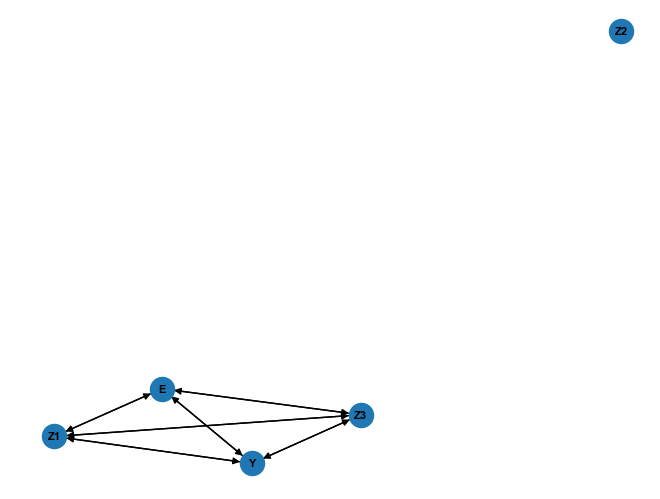

In [13]:

pc = PC(alpha = 0.2)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

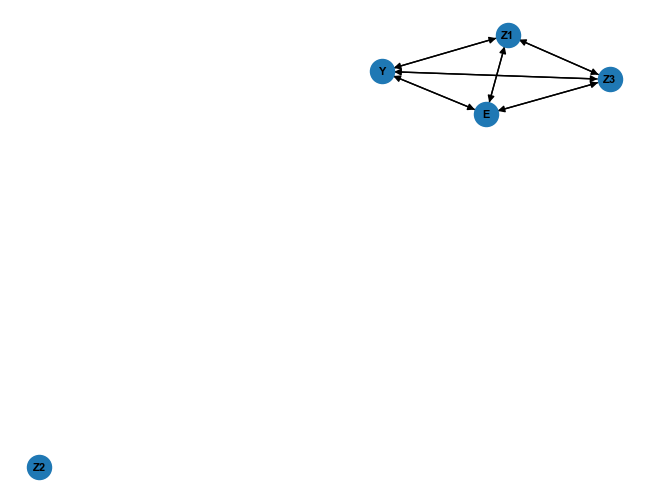

In [14]:

pc = PC(alpha = 0.35)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

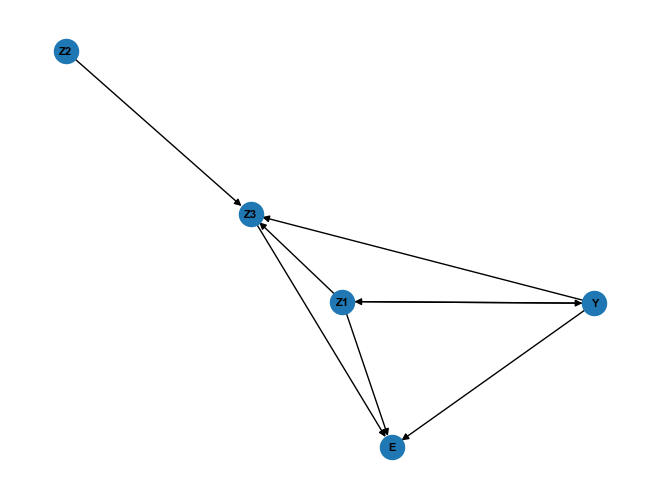

In [15]:

pc = PC(alpha = 0.4)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

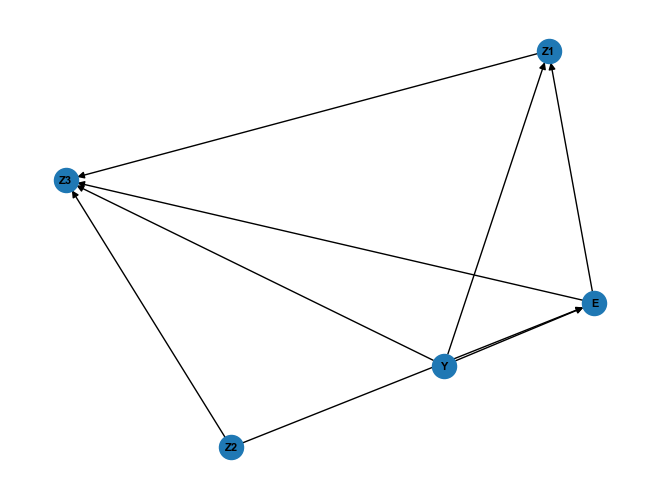

In [16]:

pc = PC(alpha = 0.6)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

# Plotting distribution - Predticted

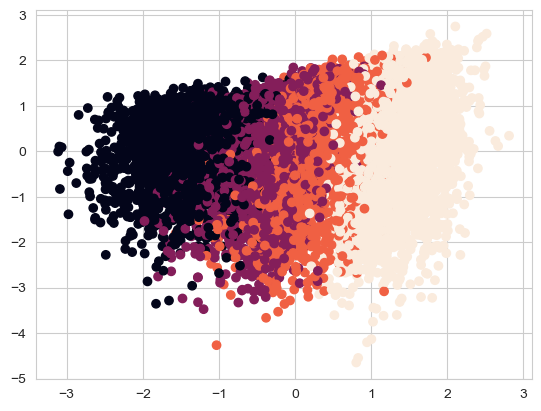

In [17]:
colors = np.array(["r", "g", "b", "y"])

plt.scatter(df["Z1"], df["Z3"], c=df["E"])

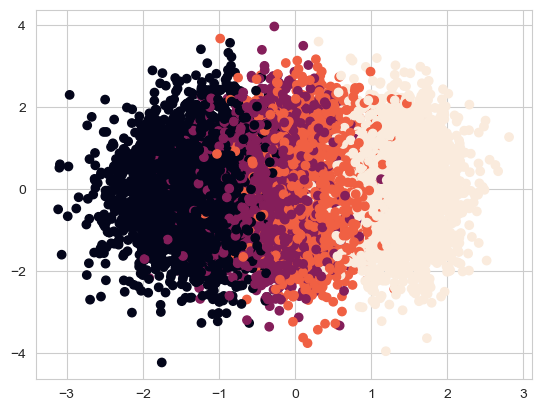

In [18]:
plt.scatter(df["Z1"], df["Z2"], c=df["E"])


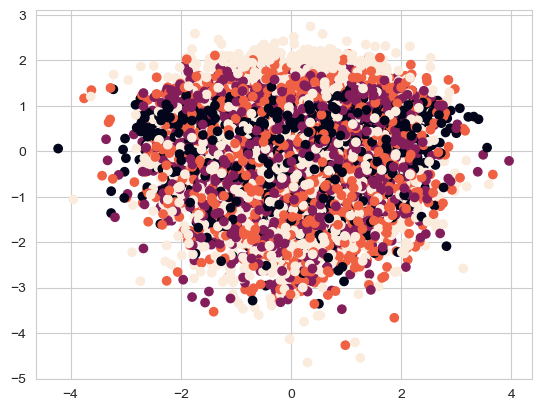

In [19]:
plt.scatter(df["Z2"], df["Z3"], c=df["E"])